In [186]:
##### import packages
#base
import os
import sys
from collections import defaultdict
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import random
import pyreadr
import pandas as pd
import seaborn as sns
%matplotlib inline
%autosave 30

#pyro contingency
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS
import torch
from torch.distributions import constraints
pyro.enable_validation(True)

#misc
import pickle
import torch.nn.functional as F
import itertools
import time
# import umap
# import plotly
# import plotly.graph_objs as go

# import homebrew modules
import models.tomtom_models as tm
import models.tomtom_util as tu

# some useless warnings from seaborn, suppressing here
import warnings
warnings.filterwarnings("ignore")

Autosaving every 30 seconds


In [187]:
# import pickled data
with open('../data/tomtom_data_preprocessed_withadded.pkl','rb') as f:
    [tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
    ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
    tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d] = pickle.load(f) 

In [188]:
# import K = 3 generated inferences
with open('visualization/tomtom_final_raw_noauto_data4viz.pkl','rb') as f:
   [hmeans, smeans, dmeans, stor_grp, stro_grp_prb, stor_dim_prb, grp_map, dim_map] = pickle.load(f)

# import baseline tp
with open('../data/generated/tomtom_final_raw_noauto_baseline.pkl','rb') as f:
    baseline = pickle.load(f)[0]

In [189]:
# make iterator that contains matrix indices
iters = np.ndenumerate(hmeans)

In [190]:
# each loaded inferred object is a numpy array of objects, each object is a 15*4 tensor
# process these objects into high dimensional np arrays to eliminate object-type inconsistency
def aot2a(aot):
    lot = aot.reshape(-1).tolist()
    outer_shape = list(aot.shape) # shape of the original array of tensors
    inner_shape = list(lot[0].shape) # shape of a singal tensor in the array
    final_shape = np.concatenate([outer_shape, inner_shape])
    a = torch.stack(lot).detach().numpy().reshape(final_shape)
    return a

# function to look up and return state labels
def matind2states(rind, cind, ncol = 4):
    #convert from matrix indices recorded in the inference df to row index in the states dataframe
    # if ncol = 4, remove auto transitions
    states = pd.read_csv('C:/Users/zhaoz/group-inference/data/states.csv')
    states = states[states['state1'] != states['state2']] # remove auto transition rows
    st_row = rind * ncol + cind
    return states.iloc[st_row].reset_index(drop = True)

In [191]:
# convert from array of tensors to higher dinensional arrays
[hmeans, smeans, dmeans] = [aot2a(i) for i in [hmeans, smeans, dmeans]]
baseline = aot2a(baseline)
    

In [192]:
#making a dataframe with inferences from the different models
a = np.ndindex(hmeans.shape)
df = pd.DataFrame(np.array(list(a)))
df.columns = ['step','stimfromind','stimtoind','predfromind','predtoind']
df['hmeans'] = hmeans.flatten()
df['smeans'] = smeans.flatten()
df['dmeans'] = dmeans.flatten()
df['bline'] = baseline.flatten()
# add state labels to the df
# filling in state labels - stimuli
df[['stim_from','stim_to','stim_set']] = matind2states(df['stimfromind'],df['stimtoind'])
# filling in state labels - prediction
df[['pred_from','pred_to','pred_set']] = matind2states(df['predfromind'],df['predtoind'])
# remove prediction auto-transition rows
df = df[df.pred_from != df.pred_to]

# store a copy for binned processing
dfcond = df.copy()
dfgain = df.copy()

In [193]:
# adding a few difference scores to the df
df['diff_h_s'] = (df.hmeans - df.smeans).abs()
df['diff_h_d'] = (df.hmeans - df.dmeans).abs()
df['diff_s_d'] = (df.smeans - df.dmeans).abs()
# tag whether grp or dim made a higher prediction (direction of diff)
tagmap = np.array(['grp','dim'])
df['higher_grp_dim'] = tagmap[(df['hmeans'] < df['dmeans']).astype(int)]

### Basic visual summary

<AxesSubplot:xlabel='diff_h_s', ylabel='Count'>

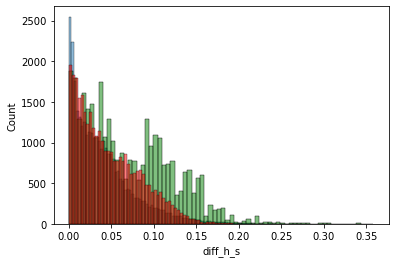

In [194]:
#  visualizing absolute difference score distributions
sns.histplot(data = df, x = 'diff_h_s',alpha = .5)
sns.histplot(data = df, x = 'diff_h_d',alpha = .5, color = 'green')
sns.histplot(data = df, x = 'diff_s_d',alpha = .5, color = 'red')

<AxesSubplot:ylabel='Count'>

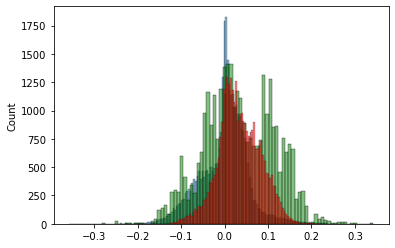

In [195]:
# plot raw differences
sns.histplot(x = df.hmeans - df.smeans,alpha = .5)
sns.histplot(x = df.hmeans - df.dmeans,alpha = .5, color = 'green')
sns.histplot(x = df.smeans - df.dmeans,alpha = .5, color = 'red')

<AxesSubplot:xlabel='higher_grp_dim', ylabel='Count'>

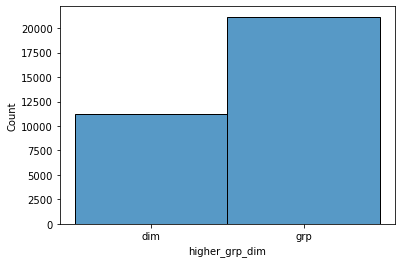

In [196]:
sns.histplot(data = df, x = 'higher_grp_dim')
# grp model very often make more extreme inferences about transition probs

In [197]:
#correlation between inferences
df[['hmeans','smeans','dmeans']].corr()

,hmeans,smeans,dmeans
hmeans,1.000000,0.960564,0.911671
smeans,0.960564,1.000000,0.966622
dmeans,0.911671,0.966622,1.000000


In [198]:
# correlation between difference scores
df[['diff_h_s','diff_h_d','diff_s_d']].corr()

,diff_h_s,diff_h_d,diff_s_d
diff_h_s,1.000000,0.434808,0.051697
diff_h_d,0.434808,1.000000,0.647013
diff_s_d,0.051697,0.647013,1.000000


### Bin into high-low conditions and then do the above

In [199]:
dfcond = dfcond.loc[(df['step'] < 3) | (df['step'] > 5)]
dfcond.loc[df['step'] < 3, 'cond'] = 'low'
dfcond.loc[df['step'] > 5, 'cond'] = 'high'

In [200]:
dfcond = dfcond.groupby(['stim_from', 'stim_to', 'stim_set',
       'pred_from', 'pred_to', 'pred_set','cond'], as_index = False).aggregate('mean')

In [201]:
# adding a few difference scores to the df
dfcond['diff_h_s'] = (dfcond.hmeans - dfcond.smeans).abs()
dfcond['diff_h_d'] = (dfcond.hmeans - dfcond.dmeans).abs()
dfcond['diff_s_d'] = (dfcond.smeans - dfcond.dmeans).abs()
# difference scores from the baseline, signed
dfcond['diff_h_b'] = dfcond.hmeans - dfcond.bline
dfcond['diff_s_b'] = dfcond.smeans - dfcond.bline
dfcond['diff_d_b'] = dfcond.dmeans - dfcond.bline # target of optim
# tag whether grp or dim made a higher prediction (direction of diff)
tagmap = np.array(['grp','dim'])
dfcond['higher_grp_dim'] = tagmap[(dfcond['hmeans'] < dfcond['dmeans']).astype(int)]

### Basic visual summary

<AxesSubplot:xlabel='diff_h_s', ylabel='Count'>

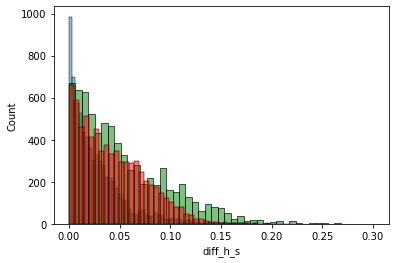

In [202]:
#  visualizing absolute difference score distributions
sns.histplot(data = dfcond, x = 'diff_h_s',alpha = .5)
sns.histplot(data = dfcond, x = 'diff_h_d',alpha = .5, color = 'green')
sns.histplot(data = dfcond, x = 'diff_s_d',alpha = .5, color = 'red')

<AxesSubplot:ylabel='Count'>

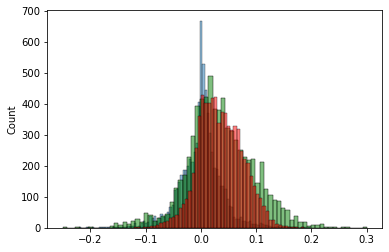

In [203]:
# plot raw differences
sns.histplot(x = dfcond.hmeans - dfcond.smeans,alpha = .5)
sns.histplot(x = dfcond.hmeans - dfcond.dmeans,alpha = .5, color = 'green')
sns.histplot(x = dfcond.smeans - dfcond.dmeans,alpha = .5, color = 'red')

<AxesSubplot:xlabel='higher_grp_dim', ylabel='Count'>

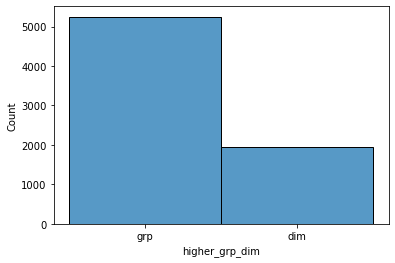

In [204]:
sns.histplot(data = dfcond, x = 'higher_grp_dim')
# grp model very often make more extreme inferences about transition probs

In [205]:
#correlation between inferences
dfcond[['hmeans','smeans','dmeans']].corr()

,hmeans,smeans,dmeans
hmeans,1.000000,0.979552,0.947597
smeans,0.979552,1.000000,0.978180
dmeans,0.947597,0.978180,1.000000


In [206]:
# correlation between difference scores
dfcond[['diff_h_s','diff_h_d','diff_s_d']].corr()

,diff_h_s,diff_h_d,diff_s_d
diff_h_s,1.000000,0.460246,0.088641
diff_h_d,0.460246,1.000000,0.685726
diff_s_d,0.088641,0.685726,1.000000


In [207]:
# adding pair columns to help selection
dfcond['stimpair'] = dfcond.stim_from.str.cat(dfcond.stim_to, sep = '-')
dfcond['predpair'] = dfcond.pred_from.str.cat(dfcond.pred_to, sep = '-')

In [208]:
# selection version 1  - only allowing each pair to appear once as as input and once as prediction
dftemp = dfcond.copy()
dfselect_once = pd.DataFrame(columns = dfcond.columns)
while not dftemp.empty:
    temp = dftemp.iloc[0]
    dfselect_once = dfselect_once.append(temp)
    dftemp = dftemp.loc[(dftemp.stimpair != temp.stimpair) & (dftemp.predpair != temp.predpair)]

<AxesSubplot:ylabel='Count'>

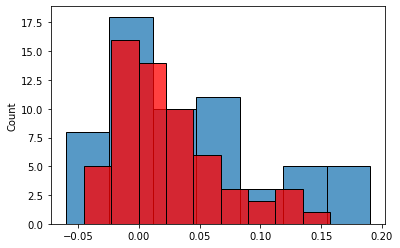

In [209]:
# plot signed differences, pos means grp predicted higher
sns.histplot(dfselect_once.diff_h_d * ((dfselect_once.higher_grp_dim == 'grp')*2-1))
sns.histplot(dfselect_once.diff_s_d * ((dfselect_once.smeans >= dfselect_once.dmeans)*2-1),color = 'red')
# shows that most of the time the grp model predicts a higher probability of transition
# generally the difference between h_d is larger than difference between s_d

In [210]:
# selectig top ten high- and low- condition trials, diff_h_d roughly match
dfselect_once.groupby('cond').head(10).groupby('cond').mean()

,hmeans,smeans,dmeans,bline,diff_h_s,diff_h_d,diff_s_d,diff_h_b,diff_s_b,diff_d_b
cond,,,,,,,,,,
high,0.617392,0.6091,0.601695,0.55355,0.018701,0.032614,0.018509,0.063842,0.05555,0.048145


## Rank and select by dim-baseline difference (information gain)

In [211]:
# Step 1. get average difference between baseline and dim model for each STIM pair
# Step 2. rank the STIMs, bin by 1/3 of the range. not binning finer to make sure there is SOMETHING in each bin
# Step 3. select 3 STIMs from each bin, make 9 STIMs
# Step 4. for each STIM, rank all pred pairs by diff_base_dim
# Step 5. wihtin STIM, preds are distriubted fairly normally. bin evenly (every ten) rather than by proportion of range
# Step 6. select 1 pred from each bin for each stim - 90 trials in total

In [212]:
dfcond['stimkey'] = dfcond.stimpair.str.cat(dfcond.cond,sep = '-')

<AxesSubplot:xlabel='diff_d_b', ylabel='Count'>

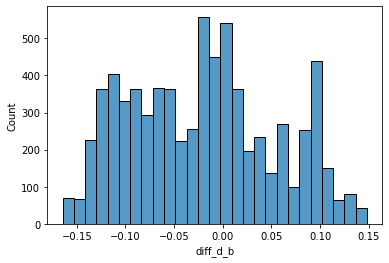

In [213]:
sns.histplot(data = dfcond, x = 'diff_d_b')


In [214]:
# step 2, binning the stim keys into thirds. mean diff between dim and baseline are bimodally distributied with the middle
# being pretty scarce, so it's unrealistic to do finer binning. 
def rankbin_stim(df):
    dftemp = df[['stimkey','diff_d_b']].groupby(
        ['stimkey'], as_index = False
    ).aggregate('mean').sort_values('diff_d_b', ascending = False)
    ranges = np.linspace(dftemp.diff_d_b.min(),dftemp.diff_d_b.max(),4) # 3 bins, choose 3 each
    binned = []
    for i in range(len(ranges)-1):
        if i != (len(ranges)-2):
            binned.append(list(dftemp.stimkey[(dftemp.diff_d_b >= ranges[i]) & (dftemp.diff_d_b < ranges[i+1])]))
        else:
            binned.append(list(dftemp.stimkey[(dftemp.diff_d_b >= ranges[i])]))
    return binned

stimbins = rankbin_stim(dfcond)

In [227]:
def rankbin_stim_edgeexplicit(df):
    dftemp = df[['stimkey','diff_d_b']].groupby(
        ['stimkey'], as_index = False
    ).aggregate('mean').sort_values('diff_d_b', ascending = False)
    
    binned = []
    binned.append(dftemp.stimkey[0:10].tolist())
    binned.append(dftemp.stimkey[10:(dftemp.shape[0]-10)].tolist())
    binned.append(dftemp.stimkey[(dftemp.shape[0]-10):dftemp.shape[0]].tolist())

    return binned

stimbins_ee = rankbin_stim_edgeexplicit(dfcond)

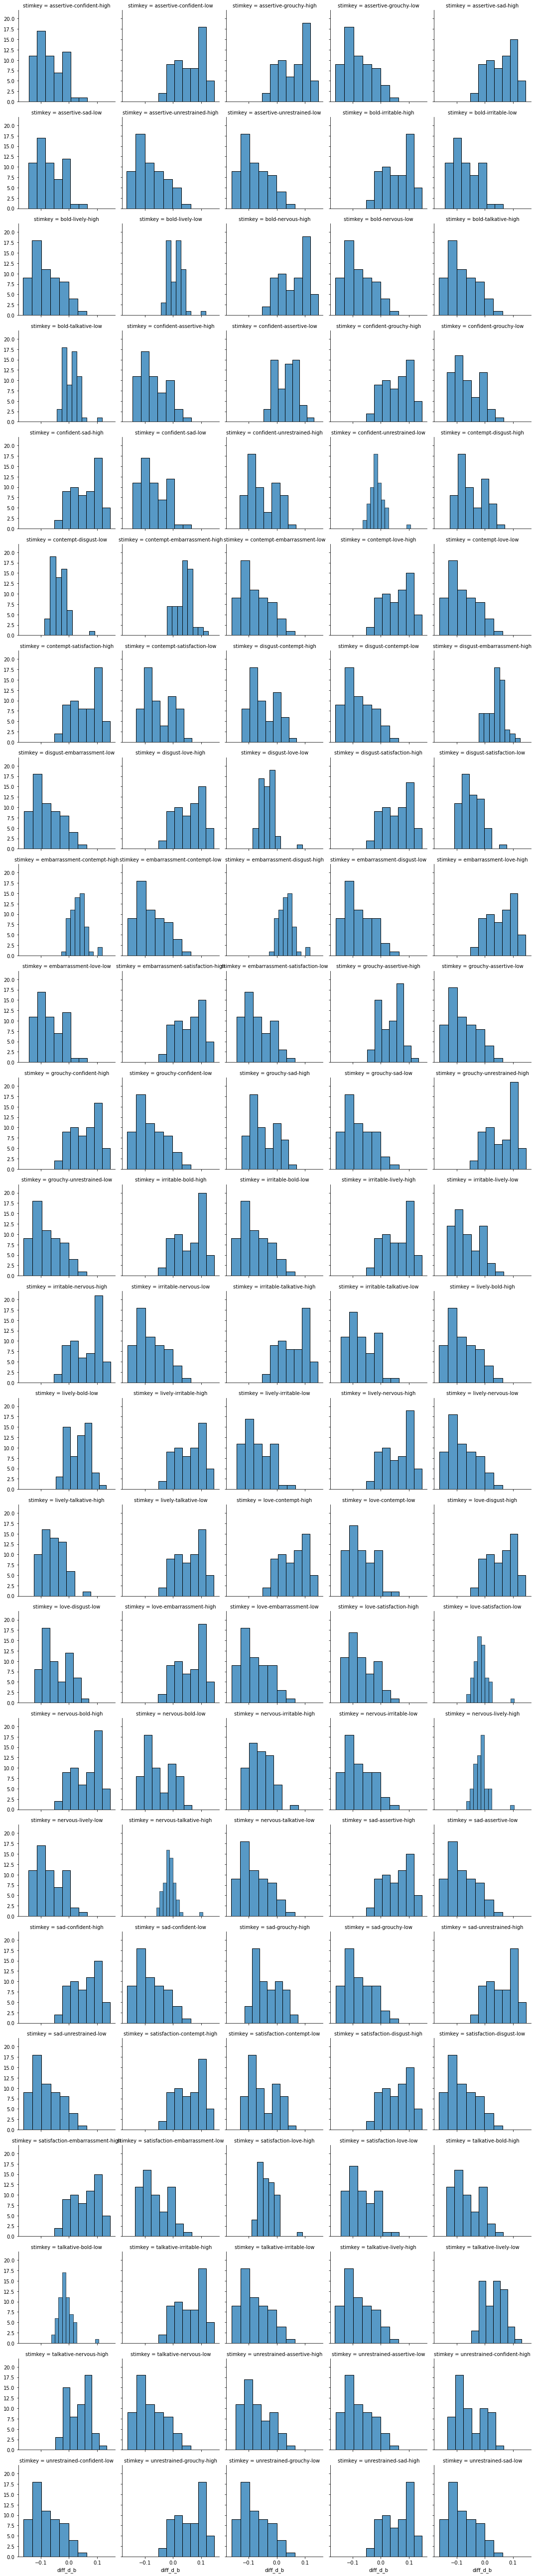

In [216]:
# visualizing the pred dist for each stimkey
a = sns.FacetGrid(data = dfcond, col='stimkey',col_wrap = 5)
a.map(sns.histplot,'diff_d_b')


In [217]:
# bin pred pairs for each 
def rankbin_pred(dfcond): 
    bin_dicts = dict()
    zerocounter = 0
    for j in dfcond.stimkey.unique():
        dfstim = dfcond.loc[dfcond.stimkey == j,['predpair','diff_d_b']]
        dfstim = dfstim.sort_values('diff_d_b',ascending = False)
        # switch to binning by rows, since nothing is THAT skewed based on the viz
        binned = np.array_split(dfstim.predpair,10)
        binned = [i.tolist() for i in binned]
        bin_dicts[j] = binned
        # see if we have any empty bins anywhere
        for i in binned:
            if len(i) ==0:
                zerocounter += 1
    print(zerocounter)
    return bin_dicts

predbins = rankbin_pred(dfcond)
        

0


0


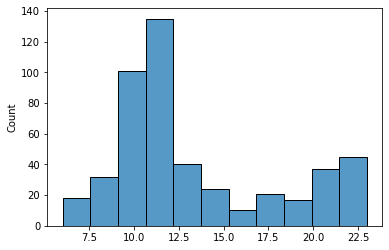

In [218]:
# alternative way to bin pred pairs, by splitting the range
def rankbin_pred_splitrange(dfcond):
    bin_dicts = dict()
    zerocounter = 0
    lens = []
    for j in dfcond.stimkey.unique():
        dfstim = dfcond.loc[dfcond.stimkey == j,['predpair','diff_d_b']]
        dfstim = dfstim.sort_values('diff_d_b',ascending = False)
        # remove the highest 3 and the lowest three
        dfstim = dfstim.iloc[3:(dfstim.shape[0]-3)]
        #
        ranges = np.linspace(dfstim.diff_d_b.min(),dfstim.diff_d_b.max(),5) # 3 bins, choose 3 each
        binned = []
        for i in range(len(ranges)-1):
            if i != (len(ranges)-2):
                binned.append(list(dfstim.predpair[(dfstim.diff_d_b >= ranges[i]) & (dfstim.diff_d_b < ranges[i+1])]))
            else:
                binned.append(list(dfstim.predpair[(dfstim.diff_d_b >= ranges[i])]))
        for i in binned:
            lens.append(len(i))
            if len(i) == 0:
                zerocounter += 1
        bin_dicts[j] = binned
    print(zerocounter)
    sns.histplot(lens)
    return bin_dicts

predbins_alt = rankbin_pred_splitrange(dfcond)

In [228]:
# alternative way to bin pred pairs, by explicitly sampling the tails
def rankbin_pred_edgeexplicit(dfcond):
    bin_dicts = dict()
    zerocounter = 0
    for j in dfcond.stimkey.unique():
        dfstim = dfcond.loc[dfcond.stimkey == j,['predpair','diff_d_b']]
        dfstim = dfstim.sort_values('diff_d_b',ascending = False)
        binned = []
        binned.append(dfstim.predpair[0:5].tolist())
        binned.append(dfstim.predpair[5:(dfstim.shape[0]-5)].tolist())
        binned.append(dfstim.predpair[(dfstim.shape[0]-5):dfstim.shape[0]].tolist())
        bin_dicts[j] = binned
    
    return bin_dicts

predbins_ee = rankbin_pred_edgeexplicit(dfcond)

In [235]:
import json

# qualtrics_input = {'stimbins': stimbins, 'predbins': predbins}
# json.dumps(qualtrics_input)

qualtircs_input = {'stimbins': stimbins_ee, 'predbins': predbins_ee}
json.dumps(qualtrics_input)

'{"stimbins": [["contempt-disgust-low", "satisfaction-love-high", "love-disgust-low", "contempt-disgust-high", "disgust-contempt-high", "grouchy-sad-high", "disgust-satisfaction-low", "satisfaction-contempt-low", "contempt-satisfaction-low", "nervous-bold-low", "confident-unrestrained-high", "unrestrained-confident-high", "lively-talkative-high", "nervous-irritable-high", "irritable-lively-low", "satisfaction-embarrassment-low", "confident-grouchy-low", "talkative-bold-high", "satisfaction-love-low", "bold-irritable-low", "love-contempt-low", "irritable-talkative-low", "lively-irritable-low", "embarrassment-love-low", "confident-sad-low", "assertive-confident-high", "assertive-sad-low", "nervous-lively-low", "embarrassment-satisfaction-low", "confident-assertive-high", "love-satisfaction-high", "unrestrained-assertive-high", "grouchy-sad-low", "nervous-irritable-low", "sad-grouchy-low", "embarrassment-disgust-low", "disgust-embarrassment-low", "embarrassment-contempt-low", "love-embarr

In [240]:
# output the model prediction dataframe
dfout = dfcond[['hmeans', 'smeans', 'dmeans', 'bline', 'diff_h_s', 'diff_h_d',
       'diff_s_d', 'diff_h_b', 'diff_s_b', 'diff_d_b', 'predpair', 'stimkey']]
dfout.to_csv('../analysis/behavior_2/tomtom_behavior2_modelpredictions.csv', index = False)

In [237]:
dfcond.columns

Index(['stim_from', 'stim_to', 'stim_set', 'pred_from', 'pred_to', 'pred_set',
       'cond', 'step', 'stimfromind', 'stimtoind', 'predfromind', 'predtoind',
       'hmeans', 'smeans', 'dmeans', 'bline', 'diff_h_s', 'diff_h_d',
       'diff_s_d', 'diff_h_b', 'diff_s_b', 'diff_d_b', 'higher_grp_dim',
       'stimpair', 'predpair', 'stimkey'],
      dtype='object')

## simulate the stimuli generation process and plotting sample level distribution

In [229]:
def single_participant(stimbins, predbins, dfcond):
    # 1.  select 3 stims from each stim bin
    stims = [random.sample(i, 3) for i in stimbins]
    stims = [j for i in stims for j in i] # un-nest
    
    # 2. one from each bin for each stim
    pred_diff = []
    for stim in stims:
        ps = predbins[stim]
        for pbin in ps:
            pred = random.sample(pbin,1)[0]
            pred_diff.extend(dfcond.loc[(dfcond.stimkey == stim) & (dfcond.predpair == pred) ,'diff_d_b'])
        
    return pred_diff

def single_participant_alt(stimbins, predbins, dfcond): # alternative to the method above, where preds are also binned by splitting range
    # 1.  select 3 stims from each stim bin
    stims = [random.sample(i, 3) for i in stimbins]
    stims = [j for i in stims for j in i] # un-nest
    
    # 2. one from each bin for each stim
    pred_diff = []
#     print(predbins[stims[0]])
    for stim in stims:
        ps = predbins[stim]
        for pbin in ps:
            pred = random.sample(pbin,3)
            for p in pred:
                pred_diff.extend(dfcond.loc[(dfcond.stimkey == stim) & (dfcond.predpair == p),'diff_d_b'])
    
    return pred_diff

def single_participant_ee(stingbins, predbins, dfcond):
    # 1.  select 3 stims from each stim bin
    stims = [random.sample(i, 3) for i in stimbins]
    stims = [j for i in stims for j in i] # un-nest
    
    # 2. one from each bin for each stim
    pred_diff = []
#     print(predbins[stims[0]])
    for stim in stims:
        ps = predbins[stim]
        pred = random.sample(ps[0],3)
        for p in pred:
            pred_diff.extend(dfcond.loc[(dfcond.stimkey == stim) & (dfcond.predpair == p),'diff_d_b'])
        pred = random.sample(ps[1],4)
        for p in pred:
            pred_diff.extend(dfcond.loc[(dfcond.stimkey == stim) & (dfcond.predpair == p),'diff_d_b'])
        pred = random.sample(ps[2],3)
        for p in pred:
            pred_diff.extend(dfcond.loc[(dfcond.stimkey == stim) & (dfcond.predpair == p),'diff_d_b'])
    return pred_diff

In [230]:
# make sample 
nsample = 200
sampleval = []
sampleval_alt = []
sampleval_ee = []
for i in range(nsample):
    sampleval.extend(single_participant(stimbins, predbins, dfcond))
    sampleval_alt.extend(single_participant_alt(stimbins, predbins_alt, dfcond))
    sampleval_ee.extend(single_participant_ee(stimbins_ee, predbins_ee, dfcond))


<AxesSubplot:ylabel='Count'>

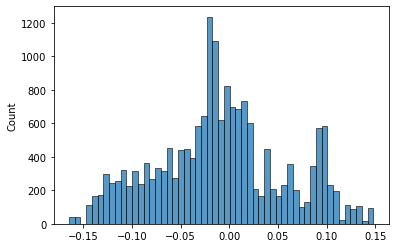

In [231]:
sns.histplot(sampleval)

<AxesSubplot:ylabel='Count'>

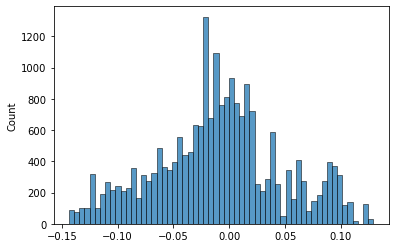

In [232]:
sns.histplot(sampleval_alt)

<AxesSubplot:ylabel='Count'>

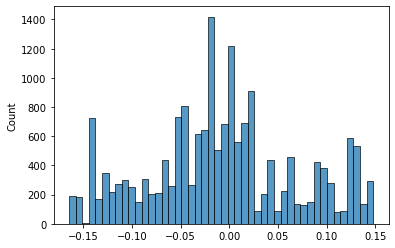

In [233]:
sns.histplot(sampleval_ee)

In [234]:
len(sampleval_ee)

18000